In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("TimeSeries_TotalSolarGen_and_Load_IT_2016.csv")
df.head(5)

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


In [3]:
df = pd.read_csv("TimeSeries_TotalSolarGen_and_Load_IT_2016.csv", 
                 parse_dates=['utc_timestamp'], 
                 index_col='utc_timestamp')

# Select the IT Load data as time series
time_series_data = df['IT_load_new']

# Handle missing values by forward filling
time_series_data.fillna(method='ffill', inplace=True)

In [4]:
series = pd.read_csv("TimeSeries_TotalSolarGen_and_Load_IT_2016.csv", 
                 parse_dates=['utc_timestamp'], 
                 index_col='utc_timestamp').squeeze("columns")

In [5]:
series.head()

,IT_load_new,IT_solar_generation
utc_timestamp,,
2016-01-01 00:00:00+00:00,21665.0,1
2016-01-01 01:00:00+00:00,20260.0,0
2016-01-01 02:00:00+00:00,19056.0,0
2016-01-01 03:00:00+00:00,18407.0,0
2016-01-01 04:00:00+00:00,18425.0,0


In [6]:
series.shape

(8784, 2)

In [7]:
df.shape

(8784, 2)

In [8]:
series.describe()

,IT_load_new,IT_solar_generation
count,8712.000000,8784.000000
mean,32262.212236,2049.831853
std,7288.629858,2845.846870
min,16716.000000,0.000000
25%,25909.500000,0.000000
50%,31654.500000,68.000000
75%,38685.750000,3923.500000
max,48986.000000,15824.000000


In [9]:
df.describe()

,IT_load_new,IT_solar_generation
count,8784.000000,8784.000000
mean,32241.997382,2049.831853
std,7262.099083,2845.846870
min,16716.000000,0.000000
25%,25944.500000,0.000000
50%,31534.500000,68.000000
75%,38637.250000,3923.500000
max,48986.000000,15824.000000


In [10]:
#Checking Stationarity using Augmented Dickey-Fuller (ADF) Test
result = adfuller(time_series_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] <= 0.05:
    print("✅ Series is stationary.")
else:
    print("⚠️ Series is not stationary. Consider differencing.")


ADF Statistic: -11.973903805672368
p-value: 3.841445170151013e-22
✅ Series is stationary.


In [11]:
# Split data into train/test
train_size = int(len(time_series_data) * 0.8)
train, test = time_series_data[:train_size], time_series_data[train_size:]

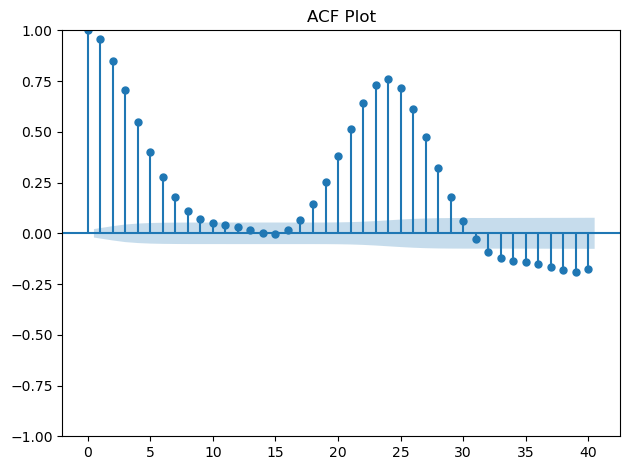

In [12]:
# ACF and PACF plots to choose lags
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plot_acf(time_series_data, lags=40)
plt.title("ACF Plot")
plt.tight_layout()
plt.show()

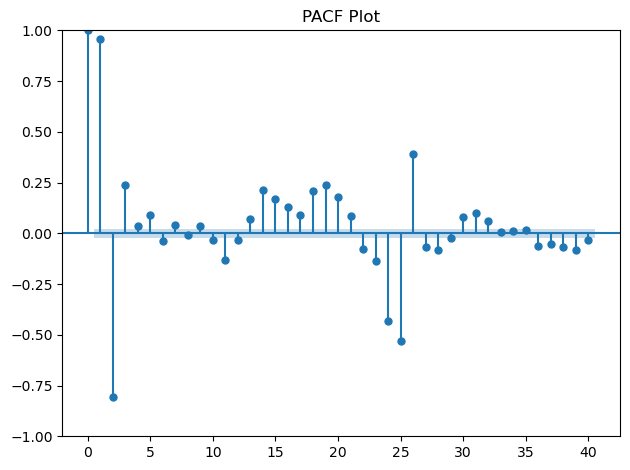

In [13]:
# PACF plot
plot_pacf(time_series_data, lags=40, method='ywm')
plt.title("PACF Plot")
plt.tight_layout()
plt.show()


In [19]:
# Train AR Model
lag = 10  # Using 10 previous values for prediction
model = AutoReg(time_series_data, lags=lag).fit()

In [20]:
# Persistence (naive) model
persistence_preds = [train.iloc[-1]] * len(test)

In [21]:
# Predicting Future Values
future_steps = 30  # Predict next 30 time points
predictions = model.predict(
    start=time_series_data.index[-1] + pd.Timedelta(hours=1),
    end=time_series_data.index[-1] + pd.Timedelta(hours=future_steps),
    dynamic=False
)

In [22]:
# Create future index for plotting
future_idx = pd.date_range(
    start=time_series_data.index[-1] + pd.Timedelta(hours=1),
    periods=future_steps,
    freq='H'
)

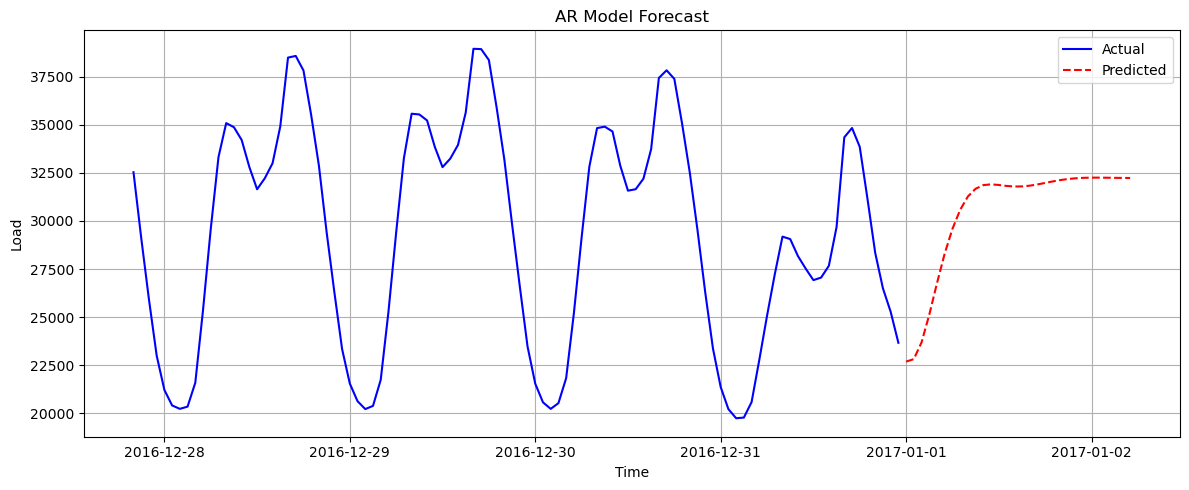

In [23]:
# Visualization of Results
# Future timestamps
# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(time_series_data[-100:], label="Actual", color='blue')
plt.plot(future_idx, predictions, label="Predicted", color='red', linestyle='--')
plt.title("AR Model Forecast")
plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# Model Summary
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:            IT_load_new   No. Observations:                 8784
Model:                    AutoReg(10)   Log Likelihood              -74440.019
Method:               Conditional MLE   S.D. of innovations           1170.541
Date:                Wed, 09 Apr 2025   AIC                         148904.037
Time:                        21:46:04   BIC                         148988.992
Sample:                    01-01-2016   HQIC                        148932.982
                         - 12-31-2016                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1639.6557     78.761     20.818      0.000    1485.286    1794.025
IT_load_new.L1      1.9370      0.011    181.554      0.000       1.916       1.958
IT_load_new.L2     -1.2519      